# Home Credit Scorecard Model 
  

## Introduction

Notebook untuk pemodelan skor kredit Home Credit Indonesia dalam Data Scientist Project-Based Internship with Rakamin.

Diberikan 7 dataset yang akan digunakan dalam pemodelan ini:
1. __application__
    
   Dataset utama yang berisi informasi pengajuan kredit.
   - 1 - Nasabah yang mengalami kesulitan pembayaran: misal mengalami keterlambatan pembayaran lebih dari X hari untuk setidaknya satu dari Y angsuran (installment) pertama pinjaman dalam sampel
   - 0 - semua kasus lainnya
2. __bureau__
    
   Dataset yang berisi informasi kredit yang diambil oleh pelanggan di lembaga keuangan lain.
3. __bureau_balance__

    Dataset yang berisi informasi pembayaran kredit di lembaga keuangan lain. 
4. __credit_card_balance__

    Dataset yang berisi saldo bulanan dari kartu kredit yang dimiliki oleh pelanggan dengan Home Credit.
5. __installments_payments__

    Dataset yang berisi riwayat pembayaran cicilan kredit yang diberikan oleh Home Credit. 
6. __pos_cash_balance__

    Dataset yang berisi saldo bulanan dari kredit POS dan kredit tunai yang dimiliki oleh pelanggan dengan Home Credit.
7. __previous_application__

    Dataset yang berisi riwayat pengajuan kredit oleh pelanggan dengan Home Credit.

## Objective

Tujuan dari notebook ini adalah membangun model skor kredit menggunakan data yang diberikan. Model ini akan digunakan untuk memprediksi apakah pengajuan kredit akan disetujui atau tidak.

Data utama yang digunakan adalah application_train.csv. 


In [1]:
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
conn = sqlite3.connect('hci_application.db')

# Exploratory Data Analysis

## Initial EDA

In [3]:
def fetch_random_n_rows(n, table_name, primary_key) -> pd.DataFrame:
    return pd.read_sql(f"""SELECT *
                       FROM {table_name}
                       WHERE {primary_key}
                       IN (
                        SELECT {primary_key}
                        FROM {table_name}
                        ORDER BY RANDOM()
                        LIMIT {n}
                       )""", conn)


In [4]:
df = pd.read_sql('SELECT * FROM application', conn)
print(df.shape)
df.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 122 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

In [6]:
df.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [7]:
# get a random sample of table for only 100 rows
prev_df = fetch_random_n_rows(100, 'previous_application', 'SK_ID_PREV')
print(prev_df.shape)
prev_df.head()

(100, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2402511,192185,Revolving loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,8,...,XNA,NaN,XNA,Card Street,NaN,NaN,NaN,NaN,NaN,NaN
1,1314233,441961,Consumer loans,10068.525,85410.0,83974.5,9000.0,85410.0,MONDAY,16,...,Connectivity,12.0,high,POS mobile with interest,365243.0,-1906.0,-1576.0,-1576.0,-1567.0,0.0
2,1837516,181413,Cash loans,18076.230,315000.0,349096.5,NaN,315000.0,SATURDAY,3,...,XNA,24.0,low_normal,Cash X-Sell: low,NaN,NaN,NaN,NaN,NaN,NaN
3,2052707,393861,Cash loans,NaN,0.0,0.0,NaN,NaN,FRIDAY,4,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
4,2677763,219878,Consumer loans,10949.490,237258.0,237780.0,23728.5,237258.0,WEDNESDAY,19,...,Consumer electronics,24.0,low_action,POS household without interest,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
prev_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SK_ID_PREV                   100 non-null    int64  
 1   SK_ID_CURR                   100 non-null    int64  
 2   NAME_CONTRACT_TYPE           100 non-null    object 
 3   AMT_ANNUITY                  72 non-null     float64
 4   AMT_APPLICATION              100 non-null    float64
 5   AMT_CREDIT                   100 non-null    float64
 6   AMT_DOWN_PAYMENT             46 non-null     float64
 7   AMT_GOODS_PRICE              74 non-null     float64
 8   WEEKDAY_APPR_PROCESS_START   100 non-null    object 
 9   HOUR_APPR_PROCESS_START      100 non-null    int64  
 10  FLAG_LAST_APPL_PER_CONTRACT  100 non-null    object 
 11  NFLAG_LAST_APPL_IN_DAY       100 non-null    int64  
 12  RATE_DOWN_PAYMENT            46 non-null     float64
 13  RATE_INTEREST_PRIMARY

In [9]:
bureau_df = fetch_random_n_rows(100, 'bureau', 'SK_ID_BUREAU')
print(bureau_df.shape)
bureau_df.head()

(100, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,249475,5199618,Closed,currency 1,-652,0,-287.0,-619.0,0.0,0,154381.50,0.0,0.0,0.0,Consumer credit,-619,NaN
1,165420,5201292,Active,currency 1,-284,0,171.0,NaN,NaN,0,109350.00,NaN,NaN,0.0,Consumer credit,-3,NaN
2,370319,5798402,Closed,currency 1,-899,0,-687.0,-776.0,NaN,0,81090.18,0.0,NaN,0.0,Consumer credit,-2,NaN
3,182014,5208846,Closed,currency 1,-2899,0,-1811.0,-1828.0,NaN,0,135000.00,NaN,NaN,0.0,Consumer credit,-1820,NaN
4,344683,5212866,Active,currency 1,-494,0,1332.0,NaN,NaN,0,443250.00,NaN,NaN,0.0,Consumer credit,-6,10188.0


In [10]:
bureau_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   SK_ID_CURR              100 non-null    int64  
 1   SK_ID_BUREAU            100 non-null    int64  
 2   CREDIT_ACTIVE           100 non-null    object 
 3   CREDIT_CURRENCY         100 non-null    object 
 4   DAYS_CREDIT             100 non-null    int64  
 5   CREDIT_DAY_OVERDUE      100 non-null    int64  
 6   DAYS_CREDIT_ENDDATE     94 non-null     float64
 7   DAYS_ENDDATE_FACT       64 non-null     float64
 8   AMT_CREDIT_MAX_OVERDUE  42 non-null     float64
 9   CNT_CREDIT_PROLONG      100 non-null    int64  
 10  AMT_CREDIT_SUM          100 non-null    float64
 11  AMT_CREDIT_SUM_DEBT     88 non-null     float64
 12  AMT_CREDIT_SUM_LIMIT    73 non-null     float64
 13  AMT_CREDIT_SUM_OVERDUE  100 non-null    float64
 14  CREDIT_TYPE             100 non-null    obj

In [11]:
bureau_df.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,100.000000,1.000000e+02,100.000000,100.0,94.000000,64.000000,42.000000,100.0,1.000000e+02,8.800000e+01,73.000000,100.0,100.000000,33.000000
mean,281503.630000,5.948349e+06,-1171.200000,0.0,442.223404,-1013.906250,1504.098214,0.0,2.332238e+05,6.774237e+04,10729.620000,0.0,-614.280000,12143.173636
std,112312.993796,5.430959e+05,830.563846,0.0,4889.393102,763.080967,3297.924264,0.0,4.304158e+05,2.063403e+05,51152.073437,0.0,690.076808,23880.208785
min,105708.000000,5.043414e+06,-2899.000000,0.0,-2623.000000,-2711.000000,0.000000,0.0,0.000000e+00,-6.156000e+01,0.000000,0.0,-2711.000000,0.000000
25%,179447.500000,5.484829e+06,-1735.750000,0.0,-1171.250000,-1488.250000,0.000000,0.0,4.622512e+04,0.000000e+00,0.000000,0.0,-878.750000,0.000000
50%,276756.000000,5.878482e+06,-923.000000,0.0,-312.000000,-787.000000,0.000000,0.0,1.073250e+05,0.000000e+00,0.000000,0.0,-383.500000,0.000000
75%,382111.000000,6.418318e+06,-489.750000,0.0,253.500000,-342.000000,0.000000,0.0,2.261250e+05,2.214242e+04,0.000000,0.0,-42.750000,11333.610000
max,455962.000000,6.840613e+06,-105.000000,0.0,31112.000000,-33.000000,14486.760000,0.0,3.612150e+06,1.408895e+06,342007.425000,0.0,-2.000000,121500.000000


## Data Cleaning

### Application Dataset

Dataset utama untuk setiap aplikasi pinjaman yang disetujui atau ditolak ditunjukkan dengan kolom TARGET.

- 1 - Nasabah yang mengalami kesulitan pembayaran: misal mengalami keterlambatan pembayaran lebih dari X hari untuk setidaknya satu dari Y angsuran (installment) pertama pinjaman dalam sampel
- 0 - semua kasus lainnya

In [12]:
missing_data = df.isnull()
missing_data.head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,True,True,True,True,True
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [13]:
for column in missing_data.columns.values.tolist():
    if missing_data[column].value_counts().get(True):
        print(missing_data[column].value_counts(), '\n')

AMT_ANNUITY
False    307499
True         12
Name: count, dtype: int64 

AMT_GOODS_PRICE
False    307233
True        278
Name: count, dtype: int64 

NAME_TYPE_SUITE
False    306219
True       1292
Name: count, dtype: int64 

OWN_CAR_AGE
True     202929
False    104582
Name: count, dtype: int64 

OCCUPATION_TYPE
False    211120
True      96391
Name: count, dtype: int64 

CNT_FAM_MEMBERS
False    307509
True          2
Name: count, dtype: int64 

EXT_SOURCE_1
True     173378
False    134133
Name: count, dtype: int64 

EXT_SOURCE_2
False    306851
True        660
Name: count, dtype: int64 

EXT_SOURCE_3
False    246546
True      60965
Name: count, dtype: int64 

APARTMENTS_AVG
True     156061
False    151450
Name: count, dtype: int64 

BASEMENTAREA_AVG
True     179943
False    127568
Name: count, dtype: int64 

YEARS_BEGINEXPLUATATION_AVG
False    157504
True     150007
Name: count, dtype: int64 

YEARS_BUILD_AVG
True     204488
False    103023
Name: count, dtype: int64 

COMMONAREA_AVG
Tr

OBS_60_CNT_SOCIAL_CIRCLE
False    306490
True       1021
Name: count, dtype: int64 

DEF_60_CNT_SOCIAL_CIRCLE
False    306490
True       1021
Name: count, dtype: int64 

DAYS_LAST_PHONE_CHANGE
False    307510
True          1
Name: count, dtype: int64 

AMT_REQ_CREDIT_BUREAU_HOUR
False    265992
True      41519
Name: count, dtype: int64 

AMT_REQ_CREDIT_BUREAU_DAY
False    265992
True      41519
Name: count, dtype: int64 

AMT_REQ_CREDIT_BUREAU_WEEK
False    265992
True      41519
Name: count, dtype: int64 

AMT_REQ_CREDIT_BUREAU_MON
False    265992
True      41519
Name: count, dtype: int64 

AMT_REQ_CREDIT_BUREAU_QRT
False    265992
True      41519
Name: count, dtype: int64 

AMT_REQ_CREDIT_BUREAU_YEAR
False    265992
True      41519
Name: count, dtype: int64 



In [14]:
excluded_column = ['SK_ID_CURR', 'TARGET', 'AMT_ANNUITY', 'COMMONAREA_AVG']

#### Drop Column

Too much missing value

- OWN_CAR_AGE
- EXT_SOURCE_1
- APARTMENTS_AVG
- BASEMENTAREA_AVG
- YEARS_BEGINEXPLUATATION_AVG
- YEARS_BUILD_AVG
- ELEVATORS_AVG
- ENTRANCES_AVG
- FLOORSMAX_AVG
- LIVINGAREA_AVG
- 

In [15]:
def has_too_many_missing_values(column: pd.Series, df, threshold=0.45):
    # A column is considered to have too many missing values if more than a certain threshold (e.g., 40%, almost half of it) of its values are missing
    return column.isnull().sum() / df.shape[0] > threshold


# drop row if it has too many missing values
df = df.drop(columns=[column for column in df.columns if
                      has_too_many_missing_values(df[column], df) and column not in excluded_column])
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### Custom Impute

- AMT_ANNUITY
- COMMONAREA_AVG -> fill na to 0

Untuk AMT_ANNUITY dapat diimpute dengan nilai rata-rata dari AMT_ANNUITY pada dataset previous_application.

In [16]:
df[df['AMT_ANNUITY'].isnull()]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
47531,155054,0,Cash loans,M,N,N,0,180000.0,450000.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
50035,157917,0,Cash loans,F,N,N,0,94500.0,450000.0,NaN,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
51594,159744,0,Cash loans,F,N,N,0,202500.0,539100.0,NaN,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,1.0
55025,163757,0,Cash loans,F,N,N,0,162000.0,296280.0,NaN,...,0,0,0,0,0.0,0.0,0.0,1.0,0.0,4.0
59934,169487,0,Cash loans,M,Y,N,0,202500.0,360000.0,NaN,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,6.0
75873,187985,0,Cash loans,M,Y,N,0,144000.0,219249.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,11.0
89343,203726,0,Cash loans,F,Y,N,0,90000.0,157500.0,NaN,...,0,0,0,0,0.0,0.0,0.0,2.0,0.0,0.0
123872,243648,0,Cash loans,F,N,Y,0,202500.0,929088.0,NaN,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,5.0
207186,340147,0,Cash loans,M,N,N,0,171000.0,486000.0,NaN,...,0,0,0,0,0.0,0.0,1.0,1.0,0.0,2.0
227939,364022,0,Cash loans,F,N,Y,0,315000.0,628069.5,NaN,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,2.0


In [17]:
prev_df_amt_annuity = pd.read_sql('SELECT SK_ID_CURR, AMT_ANNUITY FROM previous_application', conn)
prev_df_amt_annuity.head()

,SK_ID_CURR,AMT_ANNUITY
0,271877,1730.430
1,108129,25188.615
2,122040,15060.735
3,176158,47041.335
4,202054,31924.395


In [18]:
prev_df_amt_annuity_null = prev_df_amt_annuity.merge(df[df['AMT_ANNUITY'].isnull()], how='right', on='SK_ID_CURR')
prev_df_amt_annuity_null.head()

,SK_ID_CURR,AMT_ANNUITY_x,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,155054,13563.540,0,Cash loans,M,N,N,0,180000.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
1,155054,5541.210,0,Cash loans,M,N,N,0,180000.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
2,155054,4500.000,0,Cash loans,M,N,N,0,180000.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
3,155054,10997.595,0,Cash loans,M,N,N,0,180000.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
4,155054,NaN,0,Cash loans,M,N,N,0,180000.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


In [19]:
mean_amt_annuity = prev_df_amt_annuity_null[['SK_ID_CURR', 'AMT_ANNUITY_x']].groupby('SK_ID_CURR').mean()
for key, value in mean_amt_annuity.AMT_ANNUITY_x.to_dict().items():
    df.loc[df['SK_ID_CURR'] == key, 'AMT_ANNUITY'] = value

In [20]:
df.AMT_ANNUITY.isnull().sum()

0

Untuk COMMONAREA_AVG dapat diimpute dengan nilai 0 karena merupakan rata-rata luas area bersama dari apartemen klien dan nilai nya sangat skewed ke 0.

In [21]:
df.COMMONAREA_AVG.isnull().sum()

214865

<Axes: ylabel='Frequency'>

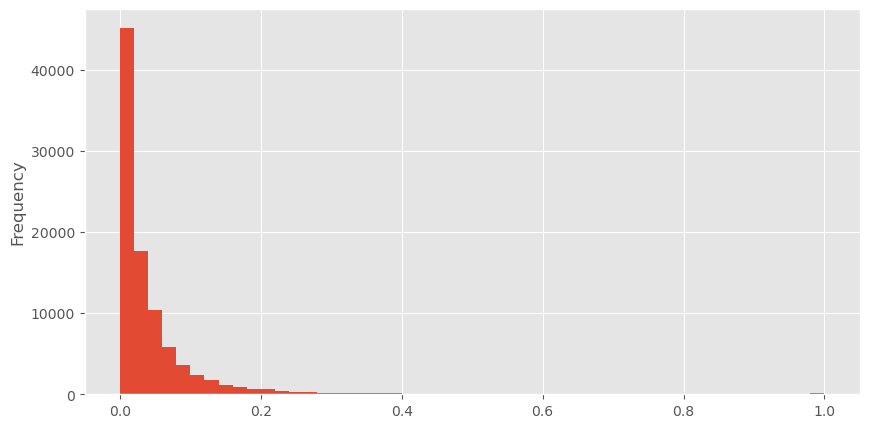

In [22]:
df.COMMONAREA_AVG.plot(kind='hist', bins=50, figsize=(10, 5))

In [23]:
df.COMMONAREA_AVG.fillna(0, inplace=True)

#### Median Impute

Jika tipe data numerik dan kontinu. Median dipilih karena kebanyakan kolom memiliki distribusi yang skewed. Contoh:

- AMT_GOODS_PRICE
- EXT_SOURCE_2
- LIVINGAPARTMENTS_AVG
- ...


<Axes: ylabel='Frequency'>

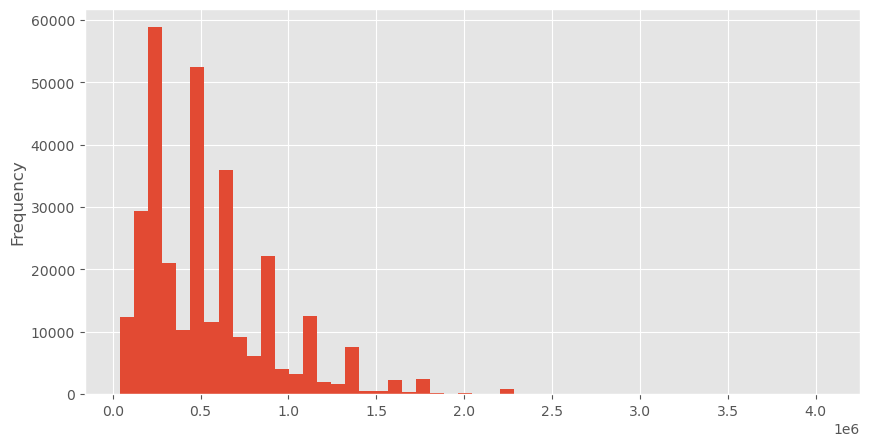

In [24]:
df['AMT_GOODS_PRICE'].plot(kind='hist', bins=50, figsize=(10, 5))

In [25]:
df[['EXT_SOURCE_2', 'TARGET']].corr()

,EXT_SOURCE_2,TARGET
EXT_SOURCE_2,1.000000,-0.160472
TARGET,-0.160472,1.000000


In [26]:
df[['EXT_SOURCE_3', 'TARGET']].corr()

,EXT_SOURCE_3,TARGET
EXT_SOURCE_3,1.000000,-0.178919
TARGET,-0.178919,1.000000


In [11]:
def fill_na_with_median(column: pd.Series):
    return column.fillna(column.median())


def is_numeric_and_continuous(column: pd.Series):
    return column.dtype.kind in 'fi' and column.nunique() / column.shape[0] > 0.01


df = df.apply(lambda x: fill_na_with_median(x) if is_numeric_and_continuous(x) and x.name not in excluded_column else x)
df.head()

#### Mode Impute

Untuk kolom kategorikal yang bertipe objek atau numerik. Contoh:

- NAME_TYPE_SUITE
- OCCUPATION_TYPE
- CNT_FAM_MEMBERS
- ...

In [28]:
df['NAME_TYPE_SUITE'].value_counts()

NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64

<Axes: xlabel='OCCUPATION_TYPE'>

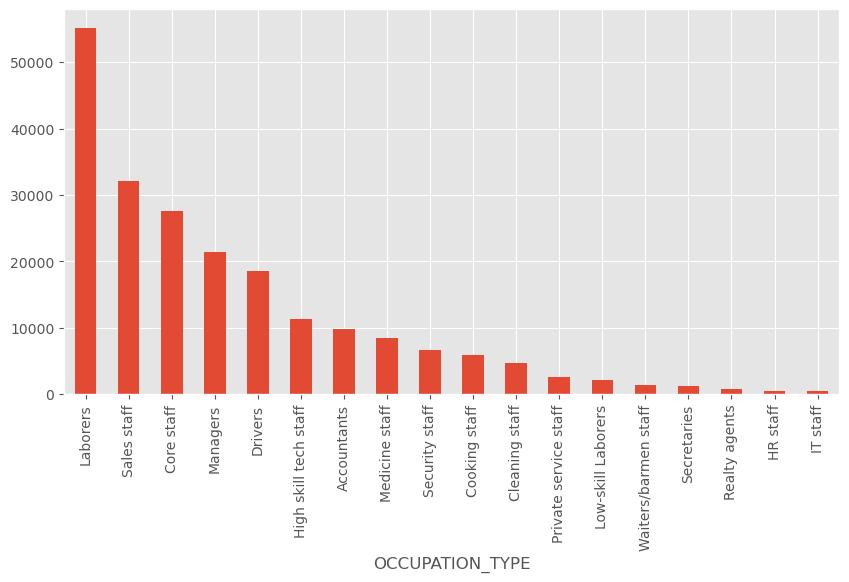

In [29]:
df['OCCUPATION_TYPE'].value_counts().plot(kind='bar', figsize=(10, 5))

In [30]:
def is_categorical(column: pd.Series):
    return column.dtype.kind in 'O' and column.nunique() / column.shape[0] < 0.01


def fill_na_with_mode(column: pd.Series):
    return column.fillna(column.mode()[0])


df = df.apply(lambda x: fill_na_with_mode(x) if is_categorical(x) and x.name not in excluded_column else x)
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


#### Leftover Missing Values

This means that the column has missing values that are not too many, and the column is not numeric and continuous. For these columns, we can impute the missing values with the median for numeric columns and the mode for categorical columns.

In [31]:
df.isnull().sum()

SK_ID_CURR                        0
TARGET                            0
NAME_CONTRACT_TYPE                0
CODE_GENDER                       0
FLAG_OWN_CAR                      0
                              ...  
AMT_REQ_CREDIT_BUREAU_DAY     41519
AMT_REQ_CREDIT_BUREAU_WEEK    41519
AMT_REQ_CREDIT_BUREAU_MON     41519
AMT_REQ_CREDIT_BUREAU_QRT     41519
AMT_REQ_CREDIT_BUREAU_YEAR    41519
Length: 74, dtype: int64

<Axes: ylabel='Frequency'>

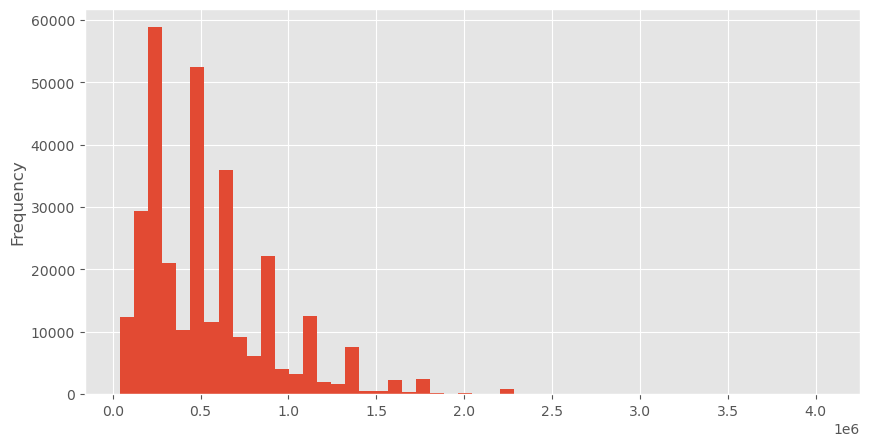

In [32]:
df.AMT_GOODS_PRICE.plot(kind='hist', bins=50, figsize=(10, 5))

In [33]:
df.AMT_GOODS_PRICE.fillna(df.AMT_GOODS_PRICE.median(), inplace=True)

<Axes: ylabel='Frequency'>

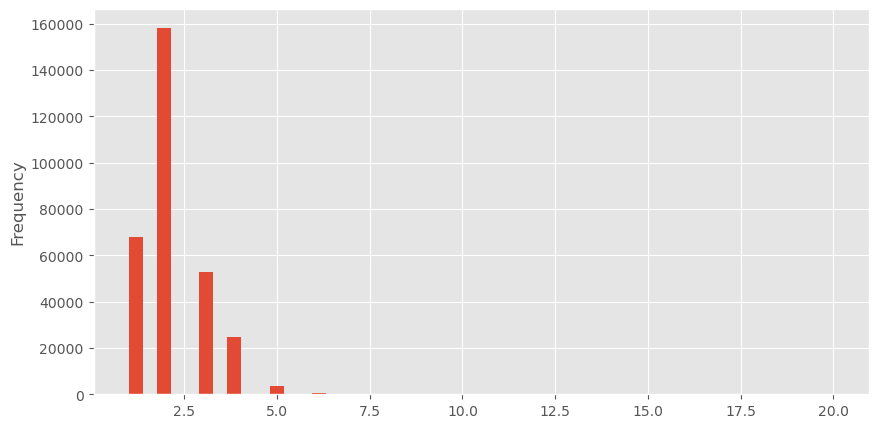

In [34]:
df.CNT_FAM_MEMBERS.plot(kind='hist', bins=50, figsize=(10, 5))

In [35]:
df.CNT_FAM_MEMBERS.fillna(df.CNT_FAM_MEMBERS.median(), inplace=True)

<Axes: ylabel='Frequency'>

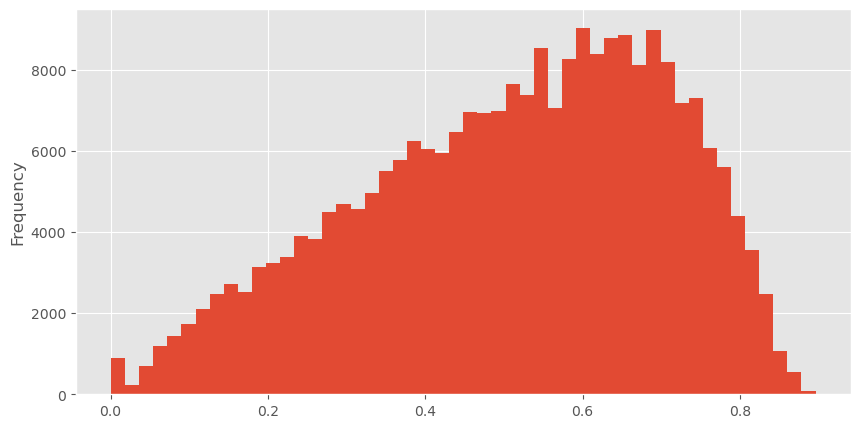

In [36]:
df.EXT_SOURCE_3.plot(kind='hist', bins=50, figsize=(10, 5))

In [37]:
df.EXT_SOURCE_3.fillna(df.EXT_SOURCE_3.median(), inplace=True)

<Axes: ylabel='Frequency'>

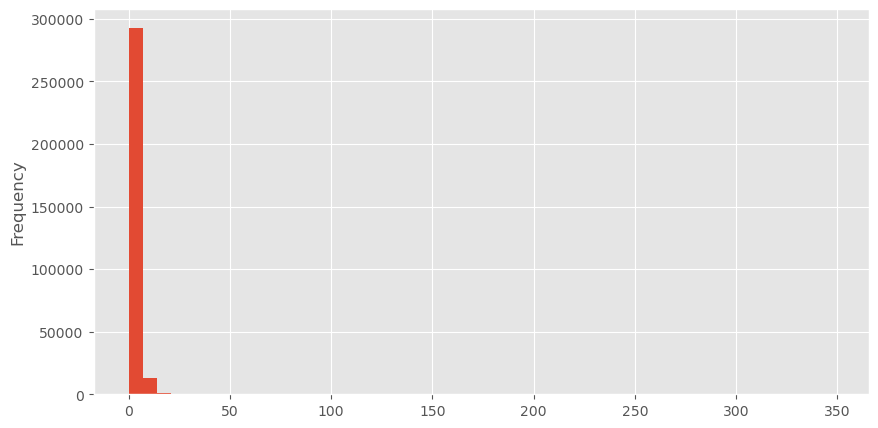

In [38]:
df.OBS_30_CNT_SOCIAL_CIRCLE.plot(kind='hist', bins=50, figsize=(10, 5))

In [39]:
df.OBS_30_CNT_SOCIAL_CIRCLE.fillna(0, inplace=True)

<Axes: ylabel='Frequency'>

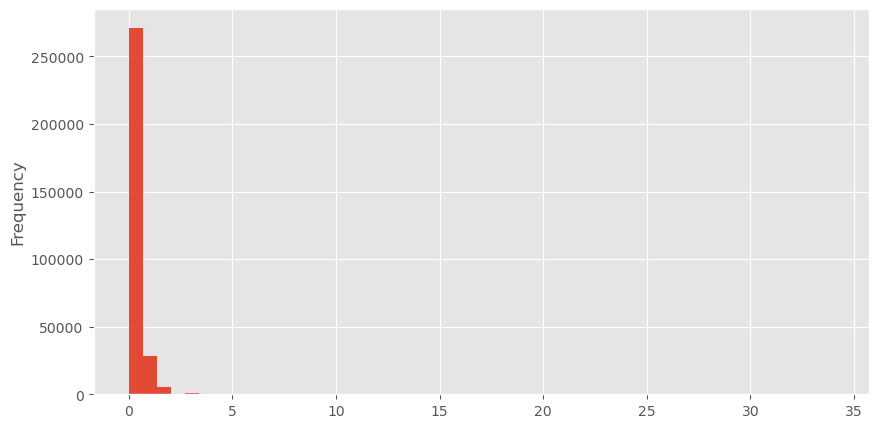

In [40]:
df.DEF_30_CNT_SOCIAL_CIRCLE.plot(kind='hist', bins=50, figsize=(10, 5))

In [41]:
df.fillna({'DEF_30_CNT_SOCIAL_CIRCLE': 0, 'DEF_60_CNT_SOCIAL_CIRCLE': 0, 'OBS_60_CNT_SOCIAL_CIRCLE': 0}, inplace=True)

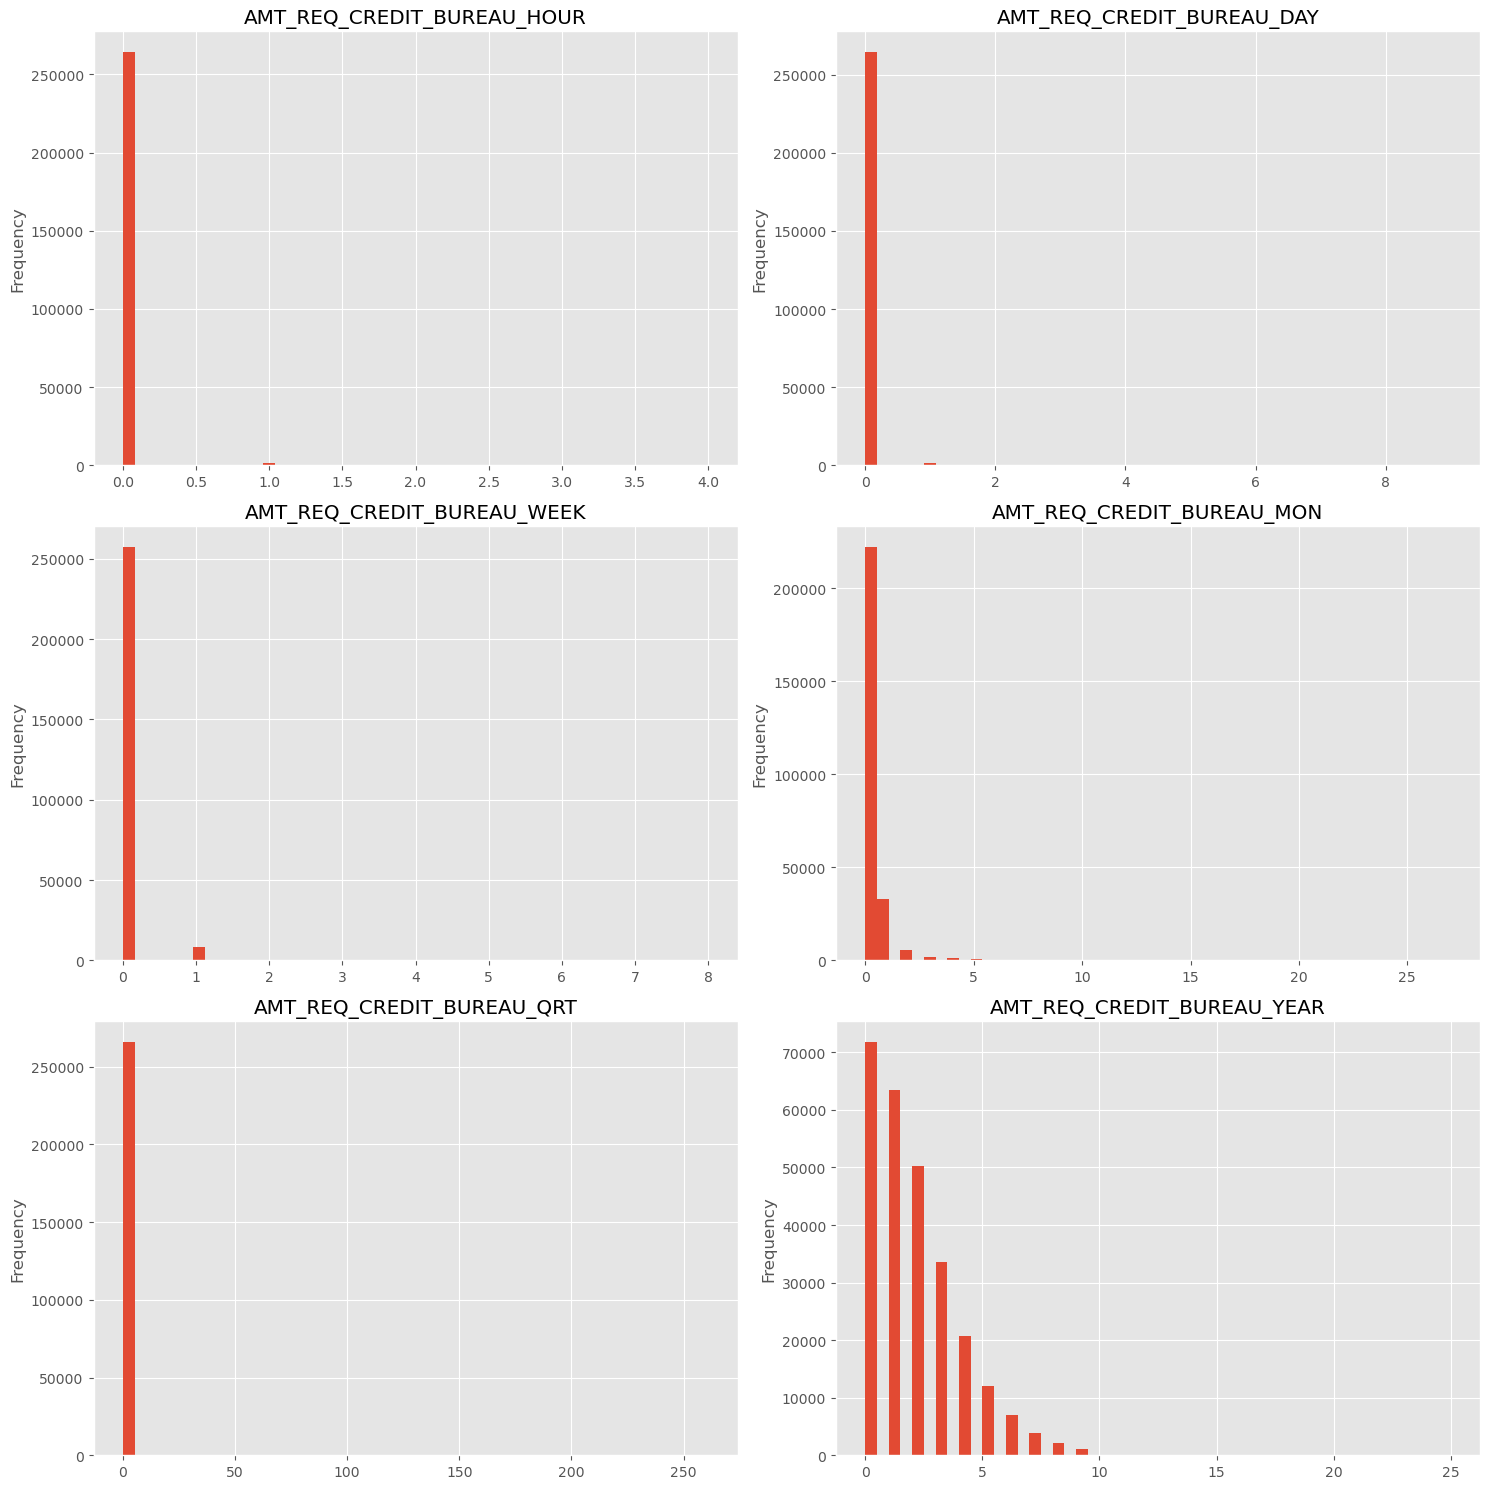

In [42]:
req_bureau_col = [x for x in df.columns if x.startswith('AMT_REQ')]

# visualize its distribution
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()

for i, col in enumerate(req_bureau_col):
    df[col].plot(kind='hist', bins=50, ax=axes[i])
    axes[i].set_title(col)
    
plt.tight_layout()
plt.show()

In [43]:
# most of the columns can be filled with 0, except for AMT_REQ_CREDIT_BUREAU_YEAR.
# AMT_REQ_CREDIT_BUREAU_YEAR will be filled with median
df.fillna({col: 0 for col in req_bureau_col[:-1]}, inplace=True)
df.fillna({'AMT_REQ_CREDIT_BUREAU_YEAR': df['AMT_REQ_CREDIT_BUREAU_YEAR'].median()}, inplace=True)

In [44]:
df.isnull().sum()

SK_ID_CURR                    0
TARGET                        0
NAME_CONTRACT_TYPE            0
CODE_GENDER                   0
FLAG_OWN_CAR                  0
                             ..
AMT_REQ_CREDIT_BUREAU_DAY     0
AMT_REQ_CREDIT_BUREAU_WEEK    0
AMT_REQ_CREDIT_BUREAU_MON     0
AMT_REQ_CREDIT_BUREAU_QRT     0
AMT_REQ_CREDIT_BUREAU_YEAR    0
Length: 74, dtype: int64

### Bureau Dataset

For bureau dataset, we can immediately join it with bureau_balance dataset to get the latest status of each credit bureau.
 
We will perform average, maximum, and count aggregation for MONTHS_BALANCE, and count aggregation for each STATUS code.

But first lets check if the identifier in bureau_balance is also available in the bureau dataset.

In [45]:
bureau_balance_id = pd.read_sql('SELECT DISTINCT SK_ID_BUREAU FROM bureau_balance', conn)
bureau_balance_id.head()

,SK_ID_BUREAU


In [46]:
bureau_balance_id = pd.read_sql('SELECT DISTINCT SK_ID_BUREAU FROM bureau_balance', conn)
bureau_balance_id.head()

,SK_ID_BUREAU


In [47]:
# check if the SK_ID_BUREAU in bureau_balance is also available in bureau
bureau_id = pd.read_sql('SELECT DISTINCT SK_ID_BUREAU FROM bureau', conn)
bureau_id.head()

,SK_ID_BUREAU
0,5714462
1,5714463
2,5714464
3,5714465
4,5714466


In [48]:
print('Number of unique SK_ID_BUREAU in bureau_balance:', bureau_balance_id.shape[0])
print('Number of unique SK_ID_BUREAU in bureau:', bureau_id.shape[0])
print('Number of unique SK_ID_BUREAU in bureau_balance that is also available in bureau:', bureau_balance_id.SK_ID_BUREAU.isin(bureau_id.SK_ID_BUREAU).sum())
print('Percentage of SK_ID_BUREAU in bureau_balance that is also available in bureau:', bureau_balance_id.SK_ID_BUREAU.isin(bureau_id.SK_ID_BUREAU).sum() / bureau_id.shape[0])

Number of unique SK_ID_BUREAU in bureau_balance: 0
Number of unique SK_ID_BUREAU in bureau: 1716428
Number of unique SK_ID_BUREAU in bureau_balance that is also available in bureau: 0
Percentage of SK_ID_BUREAU in bureau_balance that is also available in bureau: 0.0


The percentage is very low. No need to use bureau_balance

In [49]:
bureau_agg_query = """
SELECT
    SK_ID_CURR,
    COUNT(SK_ID_BUREAU) AS BUREAU_CREDIT_COUNT,
    SUM(AMT_CREDIT_SUM) AS TOTAL_CREDIT_SUM,
    AVG(DAYS_CREDIT) AS AVG_DAYS_CREDIT,
    MAX(DAYS_CREDIT_ENDDATE) AS MAX_DAYS_CREDIT_ENDDATE,
    SUM(AMT_CREDIT_SUM_OVERDUE) AS TOTAL_CREDIT_SUM_OVERDUE,
    COUNT(DISTINCT CREDIT_TYPE) AS CREDIT_TYPE_COUNT,
    MAX(AMT_CREDIT_MAX_OVERDUE) AS MAX_CREDIT_MAX_OVERDUE,
    SUM(CNT_CREDIT_PROLONG) AS TOTAL_CREDIT_PROLONG,
    SUM(CASE WHEN CREDIT_ACTIVE = 'Active' THEN 1 ELSE 0 END) AS ACTIVE_CREDIT_COUNT,
    SUM(CASE WHEN CREDIT_ACTIVE = 'Closed' THEN 1 ELSE 0 END) AS CLOSED_CREDIT_COUNT
FROM
    bureau
GROUP BY
    SK_ID_CURR;
"""

bureau_agg = pd.read_sql(bureau_agg_query, conn)

### Previous Application Dataset

In [50]:
prev_agg_query = """
SELECT
    SK_ID_CURR,
    COUNT(SK_ID_PREV) AS PREV_APP_COUNT,
    SUM(AMT_CREDIT) AS TOTAL_CREDIT_SUM,
    AVG(AMT_ANNUITY) AS AVG_ANNUITY,
    MAX(AMT_CREDIT) AS MAX_CREDIT_AMOUNT,
    SUM(AMT_GOODS_PRICE) AS TOTAL_GOODS_PRICE,
    AVG(AMT_DOWN_PAYMENT) AS AVG_DOWN_PAYMENT,
    COUNT(DISTINCT NAME_CONTRACT_TYPE) AS CONTRACT_TYPE_COUNT,
    SUM(CASE WHEN NAME_CONTRACT_STATUS = 'Approved' THEN 1 ELSE 0 END) AS APPROVED_COUNT,
    SUM(CASE WHEN NAME_CONTRACT_STATUS = 'Refused' THEN 1 ELSE 0 END) AS REFUSED_COUNT,
    AVG(DAYS_DECISION) AS AVG_DAYS_DECISION,
    SUM(CNT_PAYMENT) AS TOTAL_CNT_PAYMENT,
    COUNT(DISTINCT NAME_GOODS_CATEGORY) AS GOODS_CATEGORY_COUNT,
    MAX(DAYS_FIRST_DUE) AS MAX_DAYS_FIRST_DUE
FROM
    previous_application
GROUP BY
    SK_ID_CURR;
"""

prev_agg = pd.read_sql(prev_agg_query, conn)

### Saving The Table

In [53]:
df.to_parquet('application.parquet')
bureau_agg.to_parquet('bureau_agg.parquet')
prev_agg.to_parquet('prev_agg.parquet')

## Joining All The Dataset

In [1]:
import pandas as pd

# Merge the DataFrames
df = pd.read_parquet('application.parquet')\
    .merge(pd.read_parquet('bureau_agg.parquet'), how='inner', on='SK_ID_CURR')\
    .merge(pd.read_parquet('prev_agg.parquet'), how='inner', on='SK_ID_CURR')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,MAX_CREDIT_AMOUNT,TOTAL_GOODS_PRICE,AVG_DOWN_PAYMENT,CONTRACT_TYPE_COUNT,APPROVED_COUNT,REFUSED_COUNT,AVG_DAYS_DECISION,TOTAL_CNT_PAYMENT,GOODS_CATEGORY_COUNT,MAX_DAYS_FIRST_DUE
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,179055.0,179055.0,0.00,1,1,0,-606.000000,24.0,1,-565.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,1035882.0,1306309.5,3442.50,2,3,0,-1305.000000,30.0,3,-716.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,20106.0,24282.0,4860.00,1,1,0,-815.000000,4.0,1,-784.0
3,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,284400.0,903181.5,3390.75,2,6,0,-1222.833333,124.0,2,-344.0
4,100008,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,...,501975.0,778509.0,5548.50,2,4,0,-1192.000000,56.0,4,-339.0


# Preprocessing

In [2]:
missing_data = df.isnull()
for column in missing_data.columns.values.tolist():
    if missing_data[column].value_counts().get(True):
        print(missing_data[column].value_counts(), '\n')

TOTAL_CREDIT_SUM_x
False    249506
True          1
Name: count, dtype: int64 

MAX_DAYS_CREDIT_ENDDATE
False    247431
True       2076
Name: count, dtype: int64 

MAX_CREDIT_MAX_OVERDUE
False    175487
True      74020
Name: count, dtype: int64 

AVG_ANNUITY
False    249125
True        382
Name: count, dtype: int64 

TOTAL_GOODS_PRICE
False    248678
True        829
Name: count, dtype: int64 

AVG_DOWN_PAYMENT
False    234926
True      14581
Name: count, dtype: int64 

TOTAL_CNT_PAYMENT
False    249126
True        381
Name: count, dtype: int64 

MAX_DAYS_FIRST_DUE
False    248363
True       1144
Name: count, dtype: int64 



In [3]:
df = df.apply(lambda x: fill_na_with_median(x) if is_numeric_and_continuous(x) else x)
df.head()

NameError: name 'is_numeric_and_continuous' is not defined

In [ ]:
for k, v in df.isnull().sum().to_dict().items():
    if v > 0:
        print(k, v)

TOTAL_CNT_PAYMENT 381


In [ ]:
df.TOTAL_CNT_PAYMENT.fillna(df.TOTAL_CNT_PAYMENT.median(), inplace=True)

In [ ]:
# encode each object column
df = pd.get_dummies(df, drop_first=True)
df.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637,...,False,False,False,False,False,False,False,False,False,False
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188,...,False,False,False,False,False,False,False,False,False,False
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225,...,False,False,False,False,False,False,False,False,False,False
3,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038,...,False,False,False,False,False,False,False,False,False,False
4,100008,0,0,99000.0,490495.5,27517.5,454500.0,0.035792,-16941,-1588,...,False,False,False,False,False,False,False,False,False,False


# Model Development

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc, recall_score, precision_score
import mlflow
from mlflow.models import infer_signature

mlflow.set_tracking_uri('http://localhost:5000')
mlflow.set_experiment('home-credit-scorecard')


2024/05/30 11:50:58 INFO mlflow.tracking.fluent: Experiment with name 'home-credit-scorecard' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/359627193412431669', creation_time=1717069858080, experiment_id='359627193412431669', last_update_time=1717069858080, lifecycle_stage='active', name='home-credit-scorecard', tags={}>

In [5]:
X = df.drop(columns='TARGET')
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'train_test_split' is not defined

In [4]:
def classification_metrics(actual, pred) -> dict:
    return {
        'accuracy': accuracy_score(actual, pred),
        'recall': recall_score(actual, pred),
        'precision': precision_score(actual, pred),
        'roc_auc': roc_auc_score(actual, pred)
    }
